In [1]:
import requests
import warnings
import string
import joblib
import multiprocessing
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import transformers
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore")

In [2]:
def load_tweets(tweets_file="../data/preprocessed_tweet_20201619.csv", 
                from_date="2017-01-01", 
                to_date="2020-06-01", 
                count=10):
    """
    Parameters: 
        tweet_file: directory
        from_date: str
        to_date: str
        count: int (remove the rows which sentence length are less than certain integer)
    """
    cols = ["date", "time", "username", "tweet", "clean_tweet", "hashtags", 
            "likes_count", "replies_count", "retweets_count", "slang_count"]
    df = pd.read_csv(tweets_file, usecols=cols)
    print("# of total tweets: {}".format(df.shape[0]))
    df.sort_values(by="date", ascending=True, inplace=True)
    df.set_index('date', inplace=True)
    df = df.loc[from_date:to_date]
    df.reset_index(drop=False, inplace=True)
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset="tweet", inplace=True)
    df.drop_duplicates(subset="clean_tweet", inplace=True)
    df = df[df.clean_tweet.str.count('\s+').gt(count)]
    print("There are {} tweets we get.".format(df.shape[0]))
    return df

In [3]:
def transform_df(df, by="finance", k=10):
    """
    Parameters: 
        df: DataFrame
        by: "forex", "finance", "politics"
        k: int
    """
    # Group tweets by date and aggregate into a list
    df_temp = df.copy()
    df_temp = df_temp.sort_values(['date', 'finance'], ascending=False).groupby('date').head(100)
    df_temp = df_temp.groupby("date")['clean_tweet'].agg(list)
    df_temp = df_temp.reset_index(drop=False, inplace=False)
    df_temp.columns = ["date", "agg_tweets"]
    
    # Create top k tweet columns
    new_cols = ["Top {} Tweet".format(i+1) for i in range(k)]
    df_temp = df_temp.assign(**dict.fromkeys(new_cols, np.NaN))
    
    # Update every columns
    for index, row in tqdm(df_temp.iterrows(), total=df_temp.shape[0]):
        try:
            i = 1
            for tweet in row["agg_tweets"]:
                column = "Top {} Tweet".format(i)
                df_temp.loc[index, column] = tweet
                i += 1
                if i > k:
                    break
        except:
            pass
    df = df_temp.drop("agg_tweets", axis=1)
    
    return df
        
df = joblib.load("../data/df_final_v3.gzip")
df_tweet = transform_df(df, by="finance", k=20)
df_tweet["date"] = pd.to_datetime(df_tweet["date"])

In [4]:
fx = pd.read_csv("../data/Currency_Data_GBPUSD.csv", index_col=False)
fx.columns = ["currecny", "date", "Open", "High", "Low", "Close"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx.drop("currecny", axis=1, inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)

In [5]:
tweet_and_fx = pd.merge(df_tweet, fx, on=["date"])
tweet_and_fx.set_index('date', inplace=True)
del df_tweet, fx

In [6]:
train = tweet_and_fx.loc[:"2019-02-24"]
valid = tweet_and_fx.loc["2019-02-24":"2020-02-24"]
test = tweet_and_fx.loc["2020-02-24":]

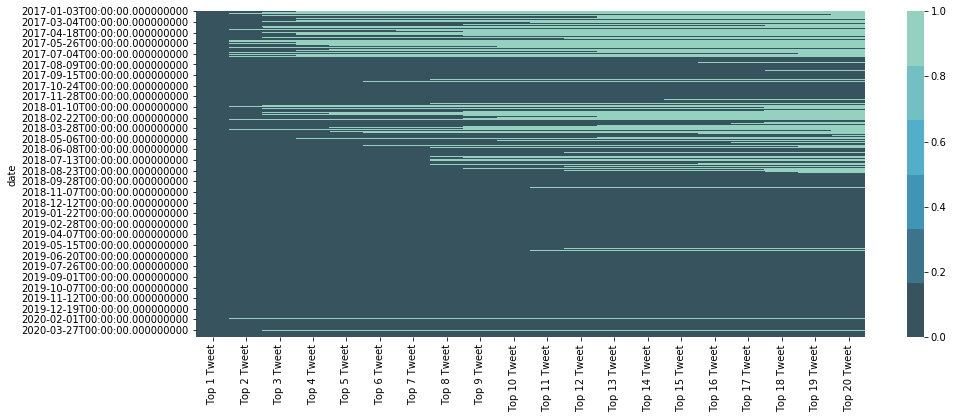

In [7]:
plt.figure(figsize=(15, 6))
sns.heatmap(tweet_and_fx.iloc[:, 0:20].isnull(), cmap=sns.color_palette("GnBu_d"))
plt.show()

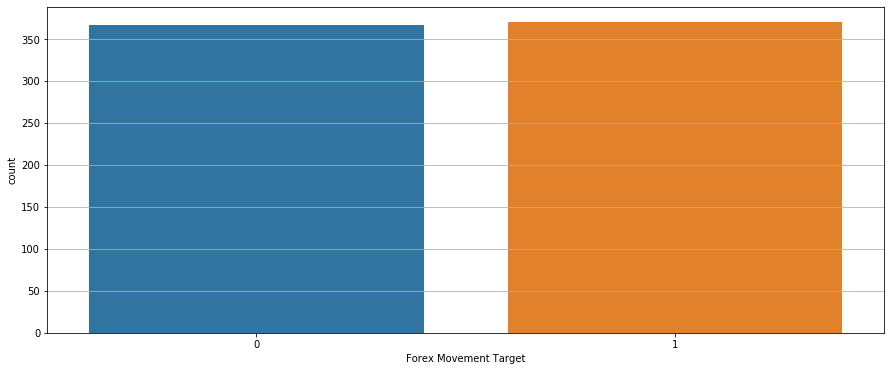

In [8]:
plt.figure(figsize=(15, 6))
sns.countplot(tweet_and_fx.label)
plt.xlabel("Forex Movement Target")
plt.grid(axis="y")

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [10]:
sample_text = tweet_and_fx.iloc[0, 0]
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Sentence: {}\n".format(sample_text))
print("Tokens: {}\n".format(tokens))
print("Tokens IDs: {}\n".format(token_ids))

Sentence: On Forbes' list of Most Powerful People,
Obama came in 48, just behind Haruhiko
Kuroda, Governor Bank of Japan.
CrowdfundEnquirer

Tokens: ['on', 'forbes', "'", 'list', 'of', 'most', 'powerful', 'people', ',', 'obama', 'came', 'in', '48', ',', 'just', 'behind', 'ha', '##ru', '##hiko', 'ku', '##rod', '##a', ',', 'governor', 'bank', 'of', 'japan', '.', 'crowd', '##fu', '##nden', '##qui', '##rer']

Tokens IDs: [2006, 10822, 1005, 2862, 1997, 2087, 3928, 2111, 1010, 8112, 2234, 1999, 4466, 1010, 2074, 2369, 5292, 6820, 22204, 13970, 14127, 2050, 1010, 3099, 2924, 1997, 2900, 1012, 4306, 11263, 25915, 15549, 14544]



In [11]:
print("[CLS] ID: ", tokenizer.cls_token_id)
print("[SEP] ID: ", tokenizer.sep_token_id)
print("[PAD] ID: ", tokenizer.pad_token_id)
print("[UNK] ID: ", tokenizer.unk_token_id)

[CLS] ID:  101
[SEP] ID:  102
[PAD] ID:  0
[UNK] ID:  100


In [12]:
encoding = tokenizer.encode_plus(
    sample_text, 
    max_length=32, 
    add_special_tokens=True, 
    return_token_type_ids=False, 
    pad_to_max_length=True, 
    return_attention_mask=True, 
    return_tensors="pt")
encoding

{'input_ids': tensor([[  101,  2006, 10822,  1005,  2862,  1997,  2087,  3928,  2111,  1010,
          8112,  2234,  1999,  4466,  1010,  2074,  2369,  5292,  6820, 22204,
         13970, 14127,  2050,  1010,  3099,  2924,  1997,  2900,  1012,  4306,
         11263,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

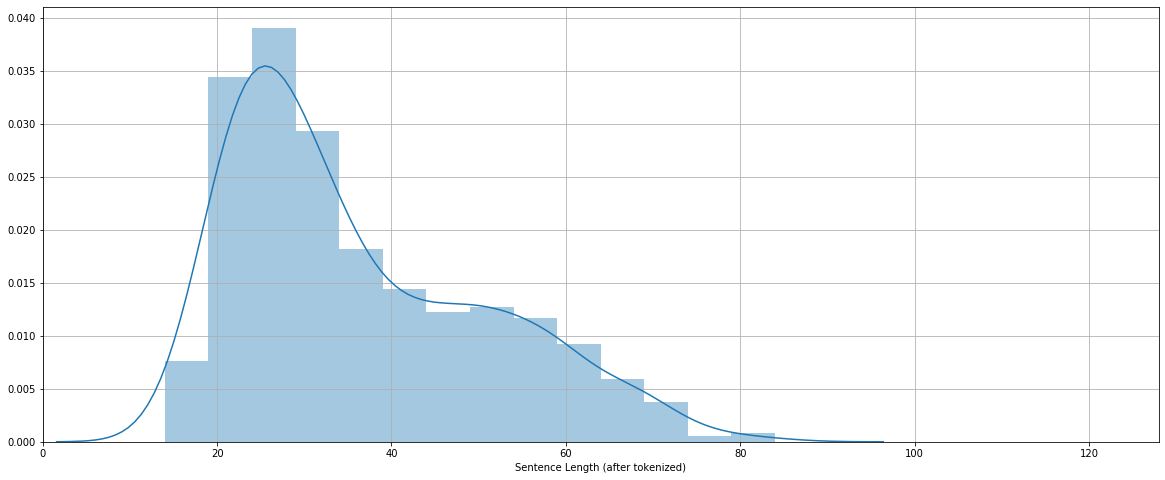

In [13]:
# Check tokenized sentence length in whole dataframe
tokens_length = []

for txt in tweet_and_fx["Top 1 Tweet"]:
    tokens = tokenizer.encode(txt, max_length=512)
    tokens_length.append(len(tokens))
    
plt.figure(figsize=(20, 8))
sns.distplot(tokens_length)
plt.grid()
plt.xlim([0, 128])
plt.xlabel("Sentence Length (after tokenized)")
plt.show()

In [14]:
def matthews_correlation_coefficient(true_pos, true_neg, false_pos, false_neg):
    nominator = (true_pos*true_neg-false_pos*false_neg) 
    denominator = np.sqrt((true_pos+false_pos)*(true_pos+false_neg)*(true_neg+false_pos)*(true_neg+false_neg)) + 1e-7
    return (nominator / denominator)

In [15]:
del tweet_and_fx

In [16]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.targets = df.label.values
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.len = len(self.df)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, item):
        top_1, top_2, top_3 = self.df.iloc[item, 1:4].values
        target = self.targets[item]
        
        encoding_1 = self.tokenizer.encode_plus(
            str(top_1), 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        encoding_2 = self.tokenizer.encode_plus(
            str(top_2), 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        encoding_3 = self.tokenizer.encode_plus(
            str(top_3), 
            max_length=self.max_len, 
            add_special_tokens=True, 
            return_token_type_ids=False, 
            pad_to_max_length=True, 
            return_attention_mask=True, 
            return_tensors="pt")
        
        return {
            "tweet_text_1": str(top_1), 
            "tweet_text_2": str(top_2), 
            "tweet_text_3": str(top_3), 
            "input_ids_1": encoding_1["input_ids"].flatten(), 
            "input_ids_2": encoding_2["input_ids"].flatten(), 
            "input_ids_3": encoding_3["input_ids"].flatten(), 
            "attention_mask_1": encoding_1["attention_mask"].flatten(), 
            "attention_mask_2": encoding_2["attention_mask"].flatten(), 
            "attention_mask_3": encoding_3["attention_mask"].flatten(), 
            "target": torch.tensor(target, dtype=torch.long)
        }
    
def create_dataloader(df, tokenizer, max_len, batch_size):
    dataset = TweetDataset(
        df=df,  
        tokenizer=tokenizer, 
        max_len=max_len)
    
    return DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0)

In [17]:
BATCH_SIZE = 16
MAX_LEN = 64

train_dataloader = create_dataloader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = create_dataloader(valid, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = create_dataloader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
class ForexMovementClassifier(nn.Module):
    def __init__(self, n_classes, p=0.25):
        super(ForexMovementClassifier, self).__init__()
        self.bert_layer_1 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert_layer_2 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.bert_layer_3 = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(p=p)
        self.classifier = nn.Linear(self.bert_layer_1.config.hidden_size*3, n_classes)
        
    def forward(self, input_ids_1, input_ids_2, input_ids_3, 
                attention_mask_1, attention_mask_2, attention_mask_3):
        _, pooled_output_1 = self.bert_layer_1(
            input_ids=input_ids_1, 
            attention_mask=attention_mask_1)
        _, pooled_output_2 = self.bert_layer_2(
            input_ids=input_ids_2, 
            attention_mask=attention_mask_2)
        _, pooled_output_3 = self.bert_layer_3(
            input_ids=input_ids_3, 
            attention_mask=attention_mask_3)
        branch_1 = self.dropout(pooled_output_1)
        branch_2 = self.dropout(pooled_output_2)
        branch_3 = self.dropout(pooled_output_3)
        main = torch.cat([branch_1, branch_2, branch_3], 1)
        return F.softmax(self.classifier(main), dim=1)

RANDOM_SEED = 417
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_name = ["down", "up"]
torch.cuda.empty_cache()
model = ForexMovementClassifier(len(class_name))
model.to(device)

EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1.0, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)
loss_function = nn.CrossEntropyLoss().to(device)

In [19]:
def train_bert(model, data_loader, loss_function, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    for data in data_loader:
        input_ids_1 = data["input_ids_1"].to(device)
        input_ids_2 = data["input_ids_2"].to(device)
        input_ids_3 = data["input_ids_3"].to(device)
        attention_mask_1 = data["attention_mask_1"].to(device)
        attention_mask_2 = data["attention_mask_2"].to(device)
        attention_mask_3 = data["attention_mask_3"].to(device)
        targets = data["target"].to(device)
        
        outputs = model(input_ids_1, input_ids_2, input_ids_3, 
                        attention_mask_1, attention_mask_2, attention_mask_3)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, targets)
        
        for p, t in zip(preds, targets):
            if p == 1 and t == 1:
                true_pos += 1
            if p == 0 and t == 0:
                true_neg += 1
            if p == 1 and t == 0:
                false_pos += 1
            if p == 0 and t == 1:
                false_neg += 1
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    recall = float(true_pos) / float(true_pos + false_neg + 1e-7)
    precision = float(true_pos) / float(true_pos + false_pos + 1e-7)
    f1 = 2 * precision * recall / (precision + recall + 1e-7)
    accuracy = (true_pos + true_neg) / float(n_examples)
    mcc = matthews_correlation_coefficient(true_pos, true_neg, false_pos, false_neg)
        
    return accuracy, f1, mcc, np.mean(losses)

def eval_bert(model, data_loader, loss_function, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    
    with torch.no_grad():
        for data in data_loader:
            input_ids_1 = data["input_ids_1"].to(device)
            input_ids_2 = data["input_ids_2"].to(device)
            input_ids_3 = data["input_ids_3"].to(device)
            attention_mask_1 = data["attention_mask_1"].to(device)
            attention_mask_2 = data["attention_mask_2"].to(device)
            attention_mask_3 = data["attention_mask_3"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids_1, input_ids_2, input_ids_3, 
                            attention_mask_1, attention_mask_2, attention_mask_3)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_function(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
            for p, t in zip(preds, targets):
                if p == 1 and t == 1:
                    true_pos += 1
                if p == 0 and t == 0:
                    true_neg += 1
                if p == 1 and t == 0:
                    false_pos += 1
                if p == 0 and t == 1:
                    false_neg += 1
                    
    recall = float(true_pos) / float(true_pos + false_neg + 1e-7)
    precision = float(true_pos) / float(true_pos + false_pos + 1e-7)
    f1 = 2 * precision * recall / (precision + recall + 1e-7)
    accuracy = (true_pos + true_neg) / float(n_examples)
    mcc = matthews_correlation_coefficient(true_pos, true_neg, false_pos, false_neg)

    return accuracy, f1, mcc, np.mean(losses)

In [20]:
%%time

history = defaultdict(list)
best_f1 = 0
path = "../checkpoint/best_bert.bin"

for epoch in range(EPOCHS):
    print("=" * 20)
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    
    train_acc, train_f1, train_mcc, train_loss = train_bert(
        model, train_dataloader, loss_function, optimizer, device, scheduler, len(train))
    
    print("Train | Loss: {:.4f} | Accuracy: {:.4f} | F1: {:.4f} | MCC: {:.4f}".format(
        train_loss, train_acc, train_f1, train_mcc))
    
    val_acc, val_f1, val_mcc, val_loss = eval_bert(
        model, val_dataloader, loss_function, device, len(valid))
    
    print("Valid | Loss: {:.4f} | Accuracy: {:.4f} | F1: {:.4f} | MCC: {:.4f}".format(
        val_loss, val_acc, val_f1, val_mcc))
    
    history["train_f1"].append(train_f1)
    history["train_mcc"].append(train_mcc)
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_f1"].append(val_f1)
    history["val_mcc"].append(val_mcc)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)
    
    
    if val_f1 > best_f1:
        torch.save(model.state_dict(), path)
        best_f1 = val_f1

Epoch 1/4
Train | Loss: 0.6902 | Accuracy: 0.5283 | F1: 0.6468 | MCC: 0.0277
Valid | Loss: 0.7128 | Accuracy: 0.4646 | F1: 0.6344 | MCC: -0.0709
Epoch 2/4
Train | Loss: 0.6888 | Accuracy: 0.5451 | F1: 0.5753 | MCC: 0.0857
Valid | Loss: 0.7057 | Accuracy: 0.5088 | F1: 0.6361 | MCC: 0.1002
Epoch 3/4
Train | Loss: 0.6174 | Accuracy: 0.6730 | F1: 0.6917 | MCC: 0.3435
Valid | Loss: 0.6852 | Accuracy: 0.5619 | F1: 0.4211 | MCC: 0.1080
Epoch 4/4
Train | Loss: 0.5113 | Accuracy: 0.8260 | F1: 0.8316 | MCC: 0.6525
Valid | Loss: 0.7268 | Accuracy: 0.5796 | F1: 0.5178 | MCC: 0.1504
Wall time: 1min 12s


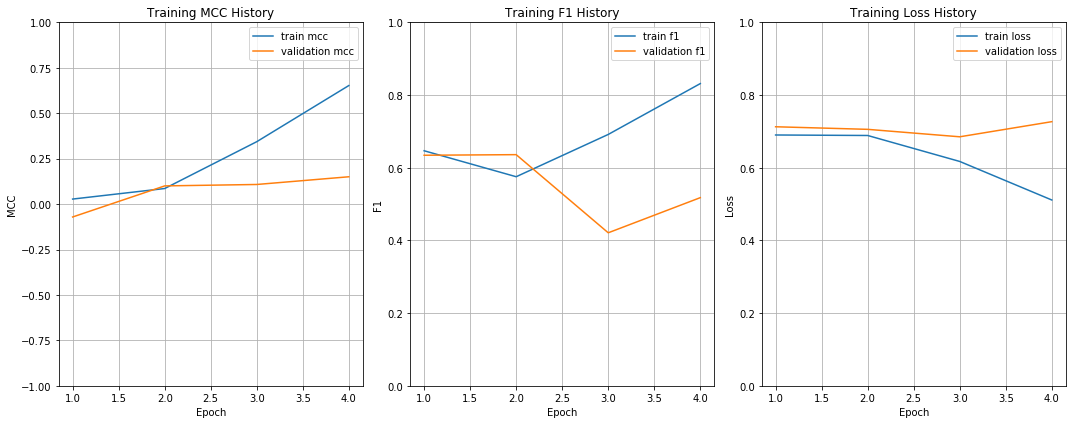

In [21]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot([int(x+1) for x in range(EPOCHS)], history["train_mcc"], label="train mcc")
plt.plot([int(x+1) for x in range(EPOCHS)], history["val_mcc"], label="validation mcc")
plt.title("Training MCC History")
plt.ylabel("MCC")
plt.xlabel("Epoch")
plt.ylim([-1, 1])
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot([int(x+1) for x in range(EPOCHS)], history["train_f1"], label="train f1")
plt.plot([int(x+1) for x in range(EPOCHS)], history["val_f1"], label="validation f1")
plt.title("Training F1 History")
plt.ylabel("F1")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot([int(x+1) for x in range(EPOCHS)], history["train_loss"], label="train loss")
plt.plot([int(x+1) for x in range(EPOCHS)], history["val_loss"], label="validation loss")
plt.title("Training Loss History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [22]:
test_acc, test_f1, test_mcc, _ = eval_bert(
    model, test_dataloader, loss_function, device, len(test))
print("Accuracy: ", test_acc)
print("F1 Score: ", test_f1)
print("MCC: ", test_mcc)

Accuracy:  0.5142857142857142
F1 Score:  0.514285666285718
MCC:  0.1413043477748897


In [23]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids_1 = data["input_ids_1"].to(device)
            input_ids_2 = data["input_ids_2"].to(device)
            input_ids_3 = data["input_ids_3"].to(device)
            attention_mask_1 = data["attention_mask_1"].to(device)
            attention_mask_2 = data["attention_mask_2"].to(device)
            attention_mask_3 = data["attention_mask_3"].to(device)
            targets = data["target"].to(device)

            outputs = model(input_ids_1, input_ids_2, input_ids_3, 
                            attention_mask_1, attention_mask_2, attention_mask_3)
            _, preds = torch.max(outputs, dim=1)
            
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return predictions, prediction_probs, real_values

In [24]:
y_pred, y_pred_probs, y_test = get_predictions(model, test_dataloader)
print(classification_report(y_test, y_pred, target_names=class_name, zero_division=0))

              precision    recall  f1-score   support

        down       0.75      0.39      0.51        23
          up       0.39      0.75      0.51        12

    accuracy                           0.51        35
   macro avg       0.57      0.57      0.51        35
weighted avg       0.63      0.51      0.51        35



In [25]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
    plt.figure(figsize=(10, 8))
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette("GnBu_d"))
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha="right")
    plt.xlabel("Predicted Movement")
    plt.ylabel("Target Movement")
    plt.show()

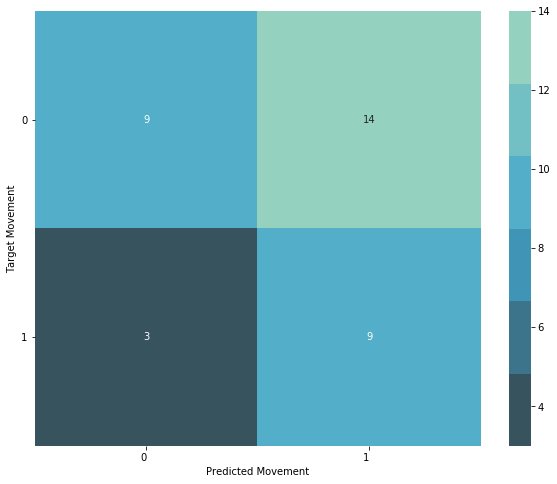

In [26]:
plot_confusion_matrix(y_test, y_pred)